# Cargue y preentrenamiento de datos

In [1]:
Etiquetas_Nombres = ['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

#***********************************************************************************************************

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Optimal_31'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta

#***********************************************************************************************************
nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

#***********************************************************************************************************

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))

#***********************************************************************************************************

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))

#***********************************************************************************************************

# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))



C:\Users\nicol\AppData\Local\Temp\ipykernel_27732\228309827.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.
Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 47, 1: 49, 2: 48, 3: 48}
Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 49, 1: 49, 2: 49, 3: 49}
Número de ejemplos de entrenamiento antes del balanceo: 192
Número de ejemplos de entrenamiento después del balanceo: 196
Número de ejemplos de prueba: 48


# Entrenamiento modelo customizado

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un modelo secuencial
modelo = Sequential()

# Agregar capas al modelo
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(4, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,740 (60.14 MB)

 Trainable params: 15,764,740 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 856ms/step - accuracy: 0.2801 - loss: 2.6878 - val_accuracy: 0.3112 - val_loss: 1.3308
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 823ms/step - accuracy: 0.3414 - loss: 1.3283 - val_accuracy: 0.3214 - val_loss: 1.2779
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 787ms/step - accuracy: 0.3297 - loss: 1.2873 - val_accuracy: 0.6684 - val_loss: 1.1521
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 810ms/step - accuracy: 0.6500 - loss: 1.1344 - val_accuracy: 0.6327 - val_loss: 0.9117
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 785ms/step - accuracy: 0.6521 - loss: 0.8834 - val_accuracy: 0.8163 - val_loss: 0.5474
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step - accuracy: 0.7909 - loss: 0.6059 - val_accuracy: 0.8316 - val_loss: 0.5087
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 777ms/step - accuracy: 0.8454 - loss: 0.4496 - val_accuracy: 0.8827 - val_loss: 0.3427
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 745ms/step - accuracy: 0.9241 - loss: 0.3009 - val_accuracy: 0.9592 - val_loss:

Precision: 0.7672413793103449
Recall: 0.5833333333333334
F1 Score: 0.5565476190476191
Accuracy: 0.5833333333333334
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.45      1.00      0.62        13
  basketball_court       1.00      0.36      0.53        11
       golf_course       1.00      0.25      0.40        12
ground_track_field       0.67      0.67      0.67        12

          accuracy                           0.58        48
         macro avg       0.78      0.57      0.55        48
      weighted avg       0.77      0.58      0.56        48



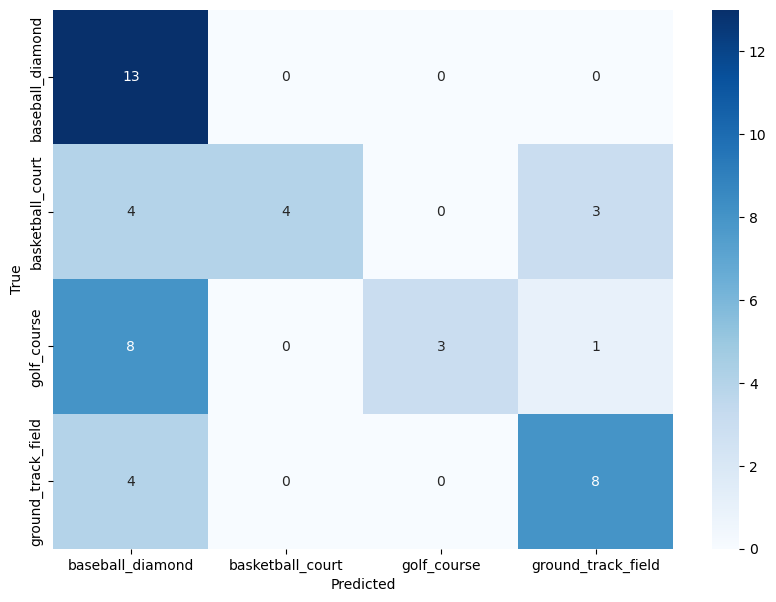

In [7]:
# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
# Supongamos que `model` es tu modelo entrenado
modelo.save('C:/Users/nicol/Desktop/Modelos/Optimal31/Optimal31_Custom.h5')

# Entrenamiento con VGG16

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  

#******************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)
#******************************************************************************************




Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.2444 - loss: 4.9933 - val_accuracy: 0.2917 - val_loss: 3.2384 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.3543 - loss: 2.6574 - val_accuracy: 0.5417 - val_loss: 1.1619 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5346 - loss: 1.2270 - val_accuracy: 0.8750 - val_loss: 0.6583 - learning_rate: 0.0010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7282 - loss: 0.6060 - val_accuracy: 0.8125 - val_loss: 0.6198 - learning_rate: 9.0484e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8001 - loss: 0.5346 - val_accuracy: 0.8958 - val_loss: 0.4535 - learning_rate: 8.1873e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8298 - loss: 0.4014 - val_accuracy: 0.8958 - val_loss: 0.4783 - learning_rate: 7.4082e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.8313 - loss: 0.4795 - val_accuracy: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Precision: 0.895541958041958
Recall: 0.8958333333333334
F1 Score: 0.894891304347826
Accuracy: 0.8958333333333334
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.85      0.85      0.85        13
  basketball_court       0.91      0.91      0.91        11
       golf_course       0.92      1.00      0.96        12
ground_track_field       0.91      0.83      0.87        12

          accuracy                           0.90        48
         macro avg       0.90      0.90      0.90        48
      weighted avg       0.90      0.90      0.89        48



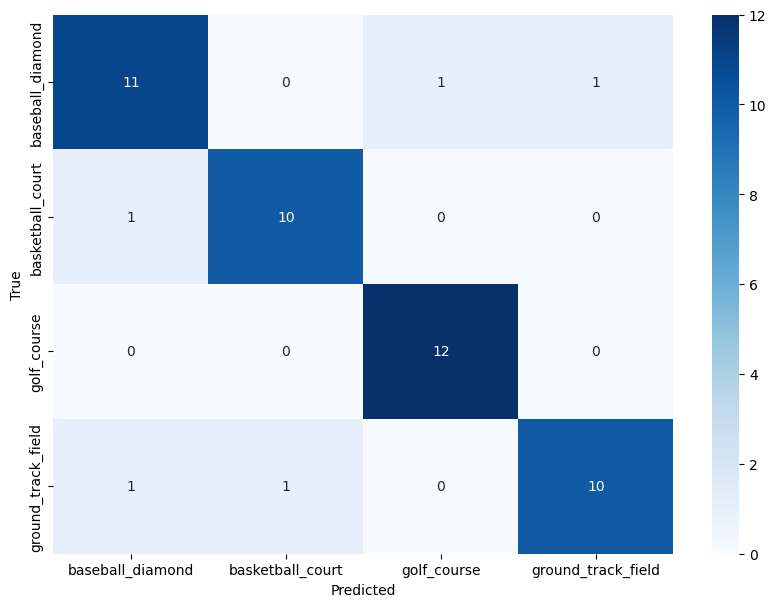

In [7]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/Optimal31/Optimal31_VGG16.h5')

# Modelo Preentrenado Xception con ImageNet

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  

#*********************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3353 - loss: 10.4682 - val_accuracy: 0.6667 - val_loss: 2.7861 - learning_rate: 0.0010
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6950 - loss: 5.5942 - val_accuracy: 0.6250 - val_loss: 6.6474 - learning_rate: 0.0010
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7698 - loss: 4.5672 - val_accuracy: 0.8542 - val_loss: 1.6076 - learning_rate: 0.0010
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9143 - loss: 0.9157 - val_accuracy: 0.8333 - val_loss: 1.2498 - learning_rate: 9.0484e-04
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9546 - loss: 0.5653 - val_accuracy: 0.7917 - val_loss: 1.0301 - learning_rate: 8.1873e-04
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9805 - loss: 0.0708 - val_accuracy: 0.8125 - val_loss: 0.9344 - learning_rate: 7.4082e-04
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9381 - loss: 0.1691 - val_accuracy: 0

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Precision: 0.9004120879120879
Recall: 0.8958333333333334
F1 Score: 0.8955134680134679
Accuracy: 0.8958333333333334
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.86      0.92      0.89        13
  basketball_court       0.82      0.82      0.82        11
       golf_course       0.92      1.00      0.96        12
ground_track_field       1.00      0.83      0.91        12

          accuracy                           0.90        48
         macro avg       0.90      0.89      0.89        48
      weighted avg       0.90      0.90      0.90        48



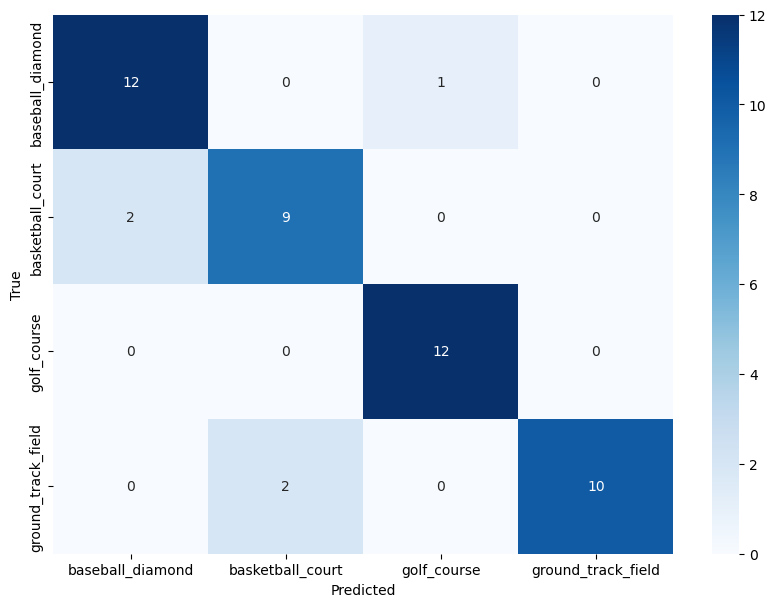

In [17]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names= Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/Optimal31/Optimal31_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [1]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Optimal_31'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (5 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.4940637914197786
Validation Loss: 1.2582839131355286
Epoch 2, Loss: 0.15572626875447376
Validation Loss: 0.6093296946492046
Epoch 3, Loss: 0.43488677378211704
Validation Loss: 2.3702831268310547
Epoch 4, Loss: 0.6305670184748513
Validation Loss: 0.7213078737258911
Epoch 5, Loss: 0.16334009606258146
Validation Loss: 0.17629992216825485
Epoch 6, Loss: 0.21988979248063906
Validation Loss: 0.13183051347732544
Epoch 7, Loss: 0.036321359287415235
Validation Loss: 0.11128721386194229
Epoch 8, Loss: 0.03677162767520973
Validation Loss: 0.11816946044564247
Epoch 9, Loss: 0.027558640177760805
Validation Loss: 0.10414569824934006
Epoch 10, Loss: 0.11594718880951405
Validation Loss: 0.10216321423649788
Epoch 11, Loss: 0.14277944753744773
Validation Loss: 0.1062229797244072
Epoch 12, Loss: 0.647679061362786
Validation Loss: 0.12874336540699005
Epoch 13, Loss: 0.09091327565589122
Validation Loss: 0.12852413952350616
Early stopping triggered


Precision: 0.9616720085470085
Recall: 0.9583333333333334
F1 Score: 0.9583333333333334
Accuracy: 0.9583333333333334
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       1.00      0.92      0.96        13
  basketball_court       0.92      1.00      0.96        11
       golf_course       0.92      1.00      0.96        12
ground_track_field       1.00      0.92      0.96        12

          accuracy                           0.96        48
         macro avg       0.96      0.96      0.96        48
      weighted avg       0.96      0.96      0.96        48



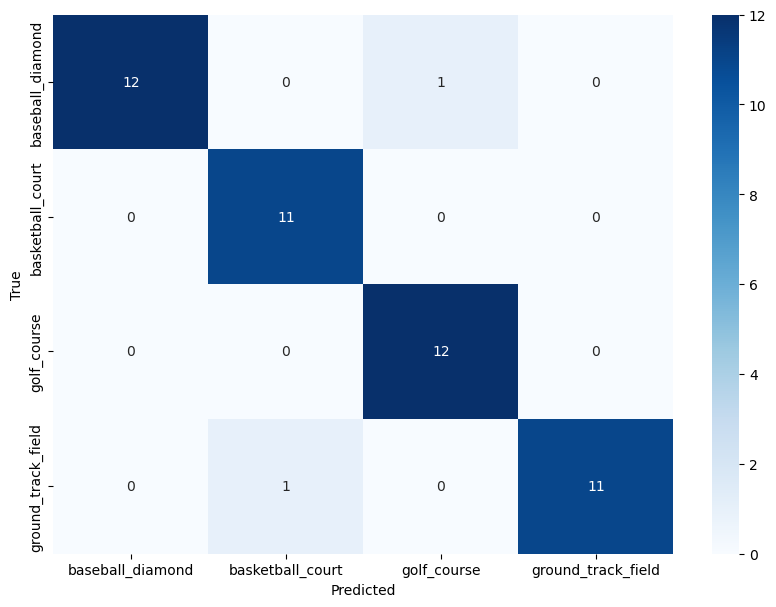

In [3]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [4]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/Optimal31/Optimal31_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [5]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['baseball_diamond', 'basketball_court', 'golf_course', 'ground_track_field']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Optimal_31'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'baseball_diamond': 0, 'basketball_court': 1, 'golf_course': 2, 'ground_track_field': 3}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa (fully connected layer) de ResNet18 para adaptarse a nuestro número de clases (5 en este caso)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7063820489815303
Validation Loss: 3.9511622190475464
Epoch 2, Loss: 0.7323487635169711
Validation Loss: 8.159680843353271
Epoch 3, Loss: 0.4129902273416519
Validation Loss: 7.374998331069946
Epoch 4, Loss: 0.21994537860155106
Validation Loss: 0.6816070824861526
Epoch 5, Loss: 0.11667226175112384
Validation Loss: 0.43818818405270576
Epoch 6, Loss: 0.05569202772208622
Validation Loss: 0.33858710527420044
Epoch 7, Loss: 0.07284601272216865
Validation Loss: 0.2777359411120415
Epoch 8, Loss: 0.05263499370110886
Validation Loss: 0.2521817646920681
Epoch 9, Loss: 0.05755790143406817
Validation Loss: 0.2315116859972477
Epoch 10, Loss: 0.04633538331836462
Validation Loss: 0.21337690576910973
Epoch 11, Loss: 0.11299144343606063
Validation Loss: 0.23959733545780182
Epoch 12, Loss: 0.06431073954861079
Validation Loss: 0.2292858213186264
Epoch 13, Loss: 0.04104148955749614
Validation Loss: 0.22101831436157227
Early stopping triggered


Precision: 0.8973023504273504
Recall: 0.8958333333333334
F1 Score: 0.8958333333333334
Accuracy: 0.8958333333333334
Classification Report:
                    precision    recall  f1-score   support

  baseball_diamond       0.92      0.85      0.88        13
  basketball_court       0.91      0.91      0.91        11
       golf_course       0.92      0.92      0.92        12
ground_track_field       0.85      0.92      0.88        12

          accuracy                           0.90        48
         macro avg       0.90      0.90      0.90        48
      weighted avg       0.90      0.90      0.90        48



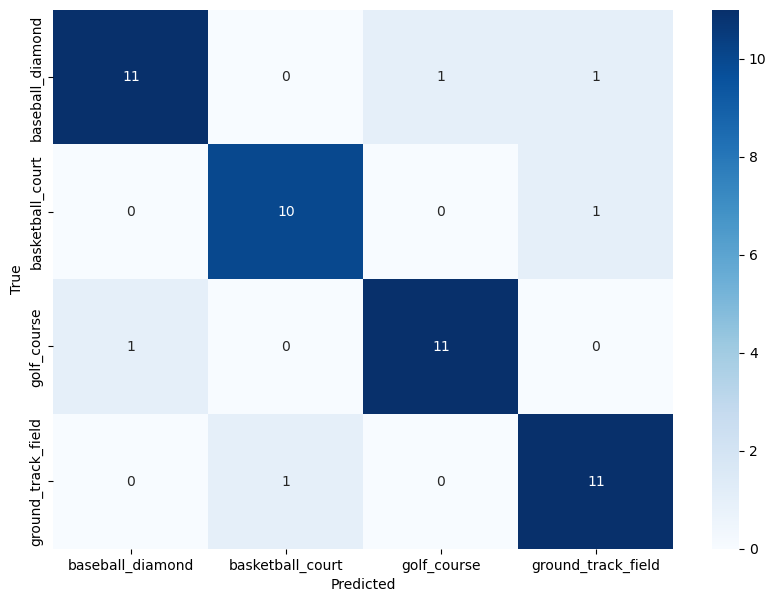

In [8]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [9]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/Optimal31/Optimal31_ResNET18.pth')